<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/17_17_RF__16_18_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import widgets
import os
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from rasterio.windows import Window
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, cross_val_predict
from tqdm import tqdm
import time
import warnings


In [2]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from skimage import morphology
import joblib

In [3]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

zip_path = input("Please paste the path to your zip file from the sidebar: ")
destination = "/content/dataset"

if os.path.exists(zip_path):
    !unzip -q "{zip_path}" -d "{destination}"
    print(f"Successfully unzipped to {destination}")
else:
    print("Error: File path not found. Did you mount your drive?")
drive.mount('/content/drive')

In [4]:

S_RGB_PATH = input("Summer RGB Path: ")
S_NDVI_PATH = input("Summer NDVI Path: ")
S_DSM = input("Summer DSM Path: ")
W_RGB_PATH = input("Winter RGB Path: ")
W_NDVI_PATH = input("Winter NDVI Path: ")
W_DSM = input("Winter DSM Path: ")
SHP_PATH = input("Shapefile (.shp) Path: ")


Summer RGB Path: /content/dataset/scraghbog/scraghbog_rgb_summer.tif
Summer NDVI Path: /content/dataset/scraghbog/Scraghbog_Summer_NDVI.tif
Summer DSM Path: /content/dataset/scraghbog/scraghbog_dem_summer.tif
Winter RGB Path: /content/dataset/scraghbog/Scraghbog_RGB_winter.tif
Winter NDVI Path: /content/dataset/scraghbog/Scraghbog_Winter_NDVI.tif
Winter DSM Path: /content/dataset/scraghbog/Scraghbog_Winter_DSM.tif
Shapefile (.shp) Path: /content/dataset/scraghbog/scraghBog_habiMap.shp


In [5]:
import rasterio
import geopandas as gpd
import os

# Define your file paths in a dictionary for easy iteration
files = {
    "Summer RGB": "/content/dataset/scraghbog/scraghbog_rgb_summer.tif",
    "Summer NDVI": "/content/dataset/scraghbog/Scraghbog_Summer_NDVI.tif",
    "Summer DSM": "/content/dataset/scraghbog/scraghbog_dem_summer.tif",
    "Winter RGB": "/content/dataset/scraghbog/Scraghbog_RGB_winter.tif",
    "Winter NDVI": "/content/dataset/scraghbog/Scraghbog_Winter_NDVI.tif",
    "Winter DSM": "/content/dataset/scraghbog/Scraghbog_Winter_DSM.tif"
}

shp_path = "/content/dataset/scraghbog/scraghBog_habiMap.shp"

print(f"{'Dataset':<15} | {'Resolution (x, y)':<25} | {'CRS'}")
print("-" * 60)

# Process Rasters
for name, path in files.items():
    if os.path.exists(path):
        with rasterio.open(path) as src:
            # res returns (x_resolution, y_resolution)
            res = src.res
            crs = src.crs.to_epsg() if src.crs else "Unknown"
            print(f"{name:<15} | {str(res):<25} | EPSG:{crs}")
    else:
        print(f"{name:<15} | File not found.")

# Process Shapefile
if os.path.exists(shp_path):
    gdf = gpd.read_file(shp_path)
    print(f"\nShapefile Bounds: {gdf.total_bounds}")
    print(f"Shapefile CRS: {gdf.crs}")

Dataset         | Resolution (x, y)         | CRS
------------------------------------------------------------
Summer RGB      | (0.029995299999999944, 0.02999529999999984) | EPSG:2157
Summer NDVI     | (0.04415057816729925, 0.044151543698846774) | EPSG:2157
Summer DSM      | (0.03489590000000139, 0.034895900000000445) | EPSG:2157
Winter RGB      | (0.03481329999999814, 0.03481329999999879) | EPSG:2157
Winter NDVI     | (0.06563180612056939, 0.06563050923390715) | EPSG:2157
Winter DSM      | (0.03481410000000176, 0.03481409999999858) | EPSG:2157

Shapefile Bounds: [641903.79713001 758404.7553     642876.3054     759768.0117    ]
Shapefile CRS: EPSG:2157


In [6]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.windows import Window
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import joblib
import warnings

warnings.filterwarnings('ignore')

In [7]:
LABEL_COL = 'fid'
NAME_COL = 'HCH_MAPPED'

gdf = gpd.read_file(SHP_PATH)


KERNEL = 17
TARGET_RES = 0.5 # 0.5m Resolution

In [8]:
fossitt_merger = {
    'GS4': 'Grassland',
    'PF1' : 'fen & flush',
    'PF3': 'bog',
    'WD4': 'Tree plantation',
    'WN6': 'willow',
    'WN7': 'bog woodland',
    'FS1': 'Swamp reeds',
    'FS2': 'Swamp',
    'FW2/WL2': 'water'
}

gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)




In [9]:
def get_optimized_features(win_data, res):
    eps = 1e-7
    # 1-3. Summer RGB (Means)
    s_rgb = np.nanmean(win_data['s_rgb'], axis=(1, 2)).astype('float64')
    # 4-6. Winter RGB (Means)
    w_rgb = np.nanmean(win_data['w_rgb'], axis=(1, 2)).astype('float64')
    # 7-8. NDVI (Means)
    s_nd = np.clip(np.nanmean(win_data['s_ndvi']), -0.9, 0.9)
    w_nd = np.clip(np.nanmean(win_data['w_ndvi']), -0.9, 0.9)

    def calc_vari(rgb):
        r, g, b = rgb[0], rgb[1], rgb[2]
        return (g - r) / (g + r - b + eps)

    s_vari = np.clip(calc_vari(s_rgb), -10, 10)
    w_vari = np.clip(calc_vari(w_rgb), -10, 10)
    s_h = np.nanmean(win_data['s_dsm'])
    w_h = np.nanmean(win_data['w_dsm'])

    def get_slope(dsm_data):
        dz_dy, dz_dx = np.gradient(dsm_data.astype('float64'), res)
        return np.nanmean(np.degrees(np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))))

    s_slope = get_slope(win_data['s_dsm'])
    w_slope = get_slope(win_data['w_dsm'])
    s_std = np.nanstd(win_data['s_rgb'][1])
    w_std = np.nanstd(win_data['w_rgb'][1])

    features = np.concatenate([
        s_rgb, w_rgb,          # 1-6
        [s_nd, w_nd],          # 7-8
        [s_vari, w_vari],      # 9-10
        [s_nd - w_nd],         # 11: Delta NDVI
        [s_h, w_h],            # 12-13: Heights
        [s_h - w_h],           # 14: Delta Height
        [s_slope, w_slope],    # 15-16: Slopes
        [s_std, w_std]         # 17-18: Texture
    ])
    return np.nan_to_num(features).astype('float32')

In [10]:
def resample_raster(path, target_res):
    with rasterio.open(path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, src.crs, src.width, src.height, *src.bounds, resolution=target_res)
        data = np.zeros((src.count, height, width), dtype='float32')
        for i in range(1, src.count + 1):
            reproject(source=rasterio.band(src, i), destination=data[i-1],
                      src_transform=src.transform, src_crs=src.crs,
                      dst_transform=transform, dst_crs=src.crs, resampling=Resampling.bilinear)
        return data, transform

# 4. LOAD AND RESAMPLE
print(f"Resampling all layers to {TARGET_RES}m...")
s_rgb, master_xf = resample_raster(S_RGB_PATH, TARGET_RES)
s_nd, _  = resample_raster(S_NDVI_PATH, TARGET_RES)
s_dsm, _ = resample_raster(S_DSM, TARGET_RES)
w_rgb, _ = resample_raster(W_RGB_PATH, TARGET_RES)
w_nd, _  = resample_raster(W_NDVI_PATH, TARGET_RES)
w_dsm, _ = resample_raster(W_DSM, TARGET_RES)

Resampling all layers to 0.5m...


In [11]:
X_list, y_list = [], []
start_time = time.time()
for _, row in tqdm(gdf.iterrows(), total=gdf.shape[0], desc="Extracting Samples"):
    geom = row.geometry
    poly_win = rasterio.windows.from_bounds(*geom.bounds, transform=master_xf).round_offsets().round_shape()
    r_off, c_off = int(poly_win.row_off), int(poly_win.col_off)
    h, w = int(poly_win.height), int(poly_win.width)

    for r in range(0, h - KERNEL, KERNEL):
        for c in range(0, w - KERNEL, KERNEL):
            cx, cy = master_xf * (c_off + c + KERNEL//2, r_off + r + KERNEL//2)
            if Point(cx, cy).within(geom):
                win_data = {
                    's_rgb': s_rgb[:, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    's_ndvi': s_nd[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    's_dsm': s_dsm[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    'w_rgb': w_rgb[:, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    'w_ndvi': w_nd[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL],
                    'w_dsm': w_dsm[0, r_off+r : r_off+r+KERNEL, c_off+c : c_off+c+KERNEL]
                }
                if np.max(win_data['s_rgb']) > 0:
                    X_list.append(get_optimized_features(win_data, TARGET_RES))
                    y_list.append(row['merged_name'])

X, y = np.array(X_list), np.array(y_list)
print(f"\nExtraction complete: {len(X)} objects in {round((time.time()-start_time)/60, 2)}m")

Extracting Samples: 100%|██████████| 18/18 [00:04<00:00,  3.96it/s]


Extraction complete: 3686 objects in 0.08m


In [12]:
rf = RandomForestClassifier(n_estimators=500, max_features='sqrt', max_samples=0.2,
                            class_weight='balanced', n_jobs=-1, random_state=42)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(rf, X, y, cv=kf)

print("\n--- 18-FEATURE CLASSIFICATION REPORT ---")
print(classification_report(y, y_pred))
rf.fit(X, y)


--- 18-FEATURE CLASSIFICATION REPORT ---
                 precision    recall  f1-score   support

      Grassland       0.91      0.62      0.74       109
          Swamp       0.87      0.66      0.75       369
    Swamp reeds       0.78      0.21      0.33        34
Tree plantation       0.96      0.94      0.95       354
            bog       0.83      0.96      0.89      1353
   bog woodland       0.85      0.93      0.88       747
    fen & flush       0.92      0.67      0.78       204
          water       0.58      0.44      0.50        16
         willow       0.86      0.74      0.79       500

       accuracy                           0.85      3686
      macro avg       0.84      0.68      0.73      3686
   weighted avg       0.86      0.85      0.85      3686



RandomForestClassifier(class_weight='balanced', max_samples=0.2,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
import joblib

# This saves it to the main folder of your Google Drive
# You can change 'My Drive/land_cover_model.pkl' to include a specific folder if you want
path = '/content/drive/My Drive/rf_model_0.5m_all classes.pkl'

joblib.dump(rf, path)

print(f"Success! Your model is now safely stored in your Google Drive at: {path}")

In [13]:
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from rasterio.features import sieve

# 1. SYNC LABEL ENCODER
# This ensures we have all 9 classes: Grassland, Swamp, Bog, etc.
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_
print(f"Detected {len(class_names)} classes: {class_names}")

Detected 9 classes: ['Grassland' 'Swamp' 'Swamp reeds' 'Tree plantation' 'bog' 'bog woodland'
 'fen & flush' 'water' 'willow']


In [14]:
h, w = s_nd.shape[1], s_nd.shape[2]
prediction_map = np.full((h, w), -1, dtype='int16')

In [15]:
# Change STEP to 10 for a massive speed boost
# This predicts a 5m x 5m area at a time (since res is 0.5m)
STEP = 10

print(f"Starting optimized classification...")
for r in tqdm(range(0, h - KERNEL, STEP)):
    for c in range(0, w - KERNEL, STEP):

        # Slicing is fast, but we only do it every 10 pixels now
        win_data = {
            's_rgb': s_rgb[:, r:r+KERNEL, c:c+KERNEL],
            's_ndvi': s_nd[0, r:r+KERNEL, c:c+KERNEL],
            's_dsm': s_dsm[0, r:r+KERNEL, c:c+KERNEL],
            'w_rgb': w_rgb[:, r:r+KERNEL, c:c+KERNEL],
            'w_ndvi': w_nd[0, r:r+KERNEL, c:c+KERNEL],
            'w_dsm': w_dsm[0, r:r+KERNEL, c:c+KERNEL]
        }

        if np.nanmax(win_data['s_rgb']) > 0:
            try:
                feat = get_optimized_features(win_data, TARGET_RES).reshape(1, -1)
                pred_label = rf.predict(feat)[0]
                idx = np.where(class_names == pred_label)[0][0]

                # Fill a larger block (10x10)
                prediction_map[r:r+STEP, c:c+STEP] = idx
            except:
                continue

Starting optimized classification...


100%|██████████| 233/233 [1:21:39<00:00, 21.03s/it]


In [16]:
prediction_map[prediction_map == -1] = 0

In [17]:
#4. ENFORCE 400m2 MMU (The Sieve)
print("\nEnforcing 400m2 Minimum Mapping Unit...")
# 400m2 / (0.5m * 0.5m) = 1600 pixels
pixel_limit = int(400 / (TARGET_RES**2))
final_map = sieve(prediction_map.astype('int16'), size=pixel_limit, connectivity=8)


Enforcing 400m2 Minimum Mapping Unit...


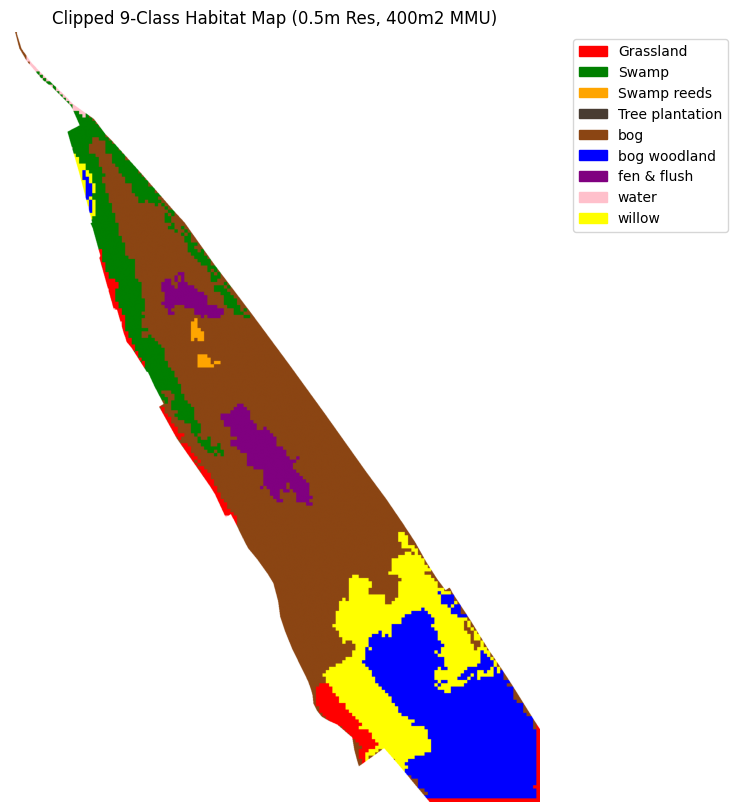

In [27]:
from rasterio import features
from rasterio.mask import mask

# 1. Create a binary mask from your shapefile
# This creates an array where 1 is inside your shapefile and 0 is outside
shapes = [(geom, 1) for geom in gdf.geometry]
mask_array = features.rasterize(
    shapes=shapes,
    out_shape=(h, w),
    transform=master_xf,
    fill=0,
    all_touched=True
)

# 2. Apply the mask to your final_map
# We set everything outside the shapefile (where mask_array == 0) to a background value
# Let's use -1 or a value that isn't one of your 9 classes
clipped_map = np.where(mask_array == 1, final_map, -1)

# 3. Visualization with Masking
plt.figure(figsize=(12, 10))

# Define colors for your 9 classes
colors = ['red', 'green', 'orange', '#483C32', '#8B4513', 'blue', 'purple', 'pink', 'yellow']
# Add a 'white' or 'transparent' color for the clipped background (-1)
cmap_colors = ['#FFFFFF'] + colors
cmap = ListedColormap(cmap_colors)

# We shift the indices by 1 so that -1 becomes 0 (White)
plt.imshow(clipped_map + 1, cmap=cmap)

plt.title(f"Clipped 9-Class Habitat Map (0.5m Res, 400m2 MMU)")

# Create legend (only for actual classes, skipping the background)
patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.axis('off')
plt.show()

In [28]:
from rasterio import features

# 1. Create a binary mask (1 inside shape, 0 outside)
# We use the same dimensions (h, w) and transform as your imagery
shapes = [(geom, 1) for geom in gdf.geometry]
mask_array = features.rasterize(
    shapes=shapes,
    out_shape=(h, w),
    transform=master_xf,
    fill=0,
    all_touched=True
)

# 2. Apply mask to the classification
# We set everything outside the shape (0) to a specific value like -1
# This effectively "cuts out" the study area
final_map_clipped = np.where(mask_array == 1, final_map, -1)

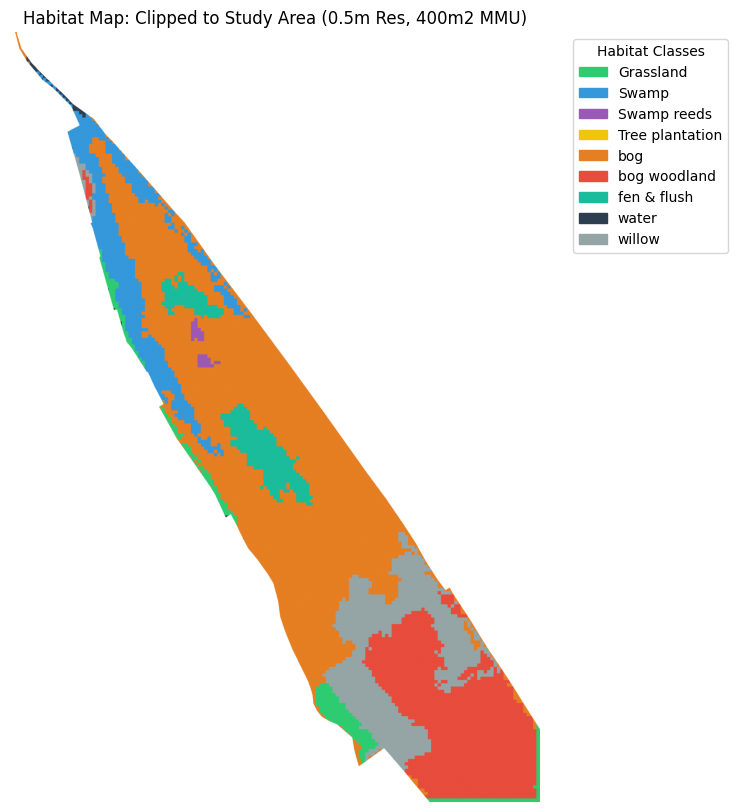

In [29]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# 3. Visualization
plt.figure(figsize=(12, 10))

# Your 9 distinct habitat colors
colors = ['#2ecc71', '#3498db', '#9b59b6', '#f1c40f', '#e67e22', '#e74c3c', '#1abc9c', '#2c3e50', '#95a5a6']

# Create a colormap where the first color (for -1) is white
# We use clipped_map + 1 so that -1 becomes index 0
cmap_colors = ['#FFFFFF'] + colors
cmap = ListedColormap(cmap_colors)

plt.imshow(final_map_clipped + 1, cmap=cmap)
plt.title(f"Habitat Map: Clipped to Study Area (0.5m Res, 400m2 MMU)")

# Create the legend for the 9 valid classes only
patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Habitat Classes")

plt.axis('off')
plt.show()

In [30]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix

# 1. Get the Cross-Validated predictions (if not already done)
# This uses the 'y' and 'y_pred' from your training block
overall_acc = accuracy_score(y, y_pred)
kappa = cohen_kappa_score(y, y_pred)

print(f"--- Global Accuracy Metrics ---")
print(f"Overall Accuracy: {overall_acc * 100:.2f}%")
print(f"Kappa Coefficient: {kappa:.4f}")
print("\n--- Detailed Class-wise Report ---")
print(classification_report(y, y_pred, target_names=class_names))

--- Global Accuracy Metrics ---
Overall Accuracy: 85.46%
Kappa Coefficient: 0.8096

--- Detailed Class-wise Report ---
                 precision    recall  f1-score   support

      Grassland       0.91      0.62      0.74       109
          Swamp       0.87      0.66      0.75       369
    Swamp reeds       0.78      0.21      0.33        34
Tree plantation       0.96      0.94      0.95       354
            bog       0.83      0.96      0.89      1353
   bog woodland       0.85      0.93      0.88       747
    fen & flush       0.92      0.67      0.78       204
          water       0.58      0.44      0.50        16
         willow       0.86      0.74      0.79       500

       accuracy                           0.85      3686
      macro avg       0.84      0.68      0.73      3686
   weighted avg       0.86      0.85      0.85      3686



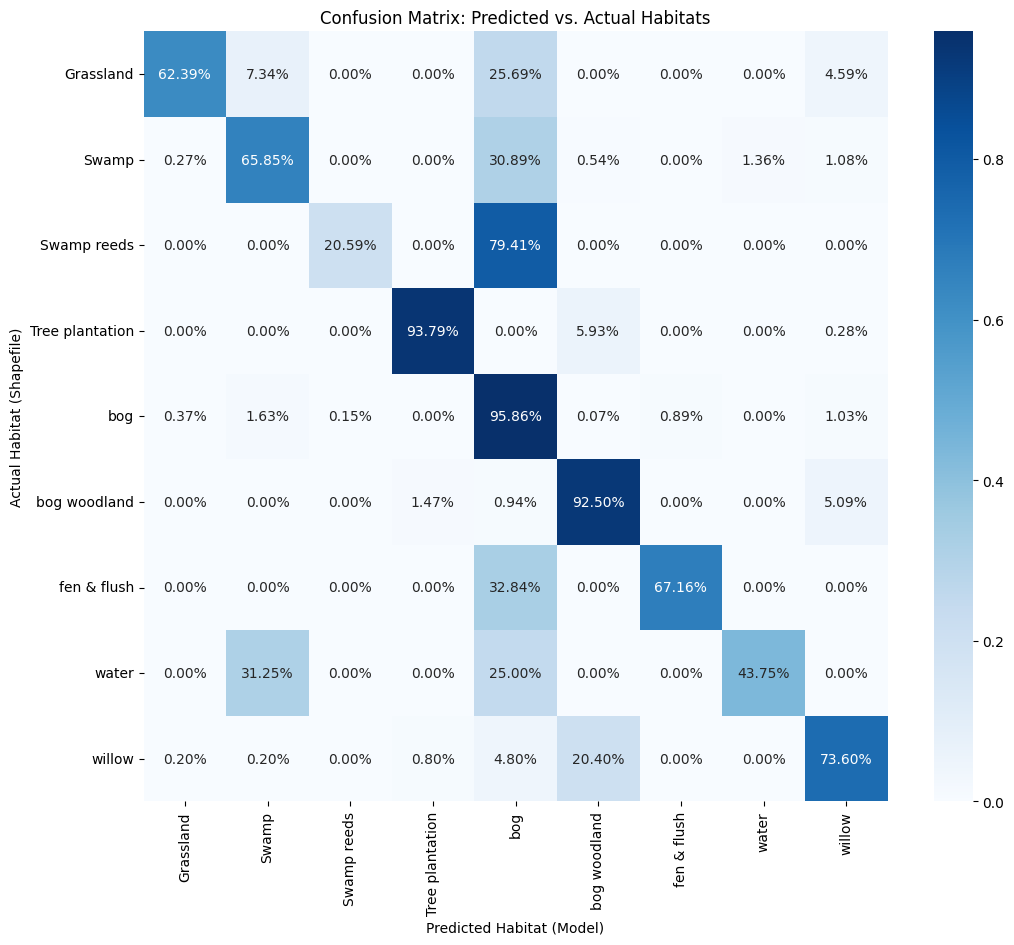

In [31]:
import seaborn as sns

# 2. Generate Confusion Matrix
cm = confusion_matrix(y, y_pred)
# Normalize to show percentages
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_perc, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix: Predicted vs. Actual Habitats')
plt.ylabel('Actual Habitat (Shapefile)')
plt.xlabel('Predicted Habitat (Model)')
plt.show()